# Credit Card Fraud Detection: Handling Imbalanced Data for Classification (Part 2)

Author: **Marcin Sikorski**<br>
Date: November, 2024

This notebook will demonstrate credit card fraud detection with simple neural networks.

**Notebook Content:**
1. Importing & Preprocessing Data
2. No Data Balancing
3. SMOTE & ENN Resampling
4. Random Undersampling
5. Conclusions

### 1. Importing & Preprocessing Data

The data will be loaded into a dataframe. We will perform the same preprocessing steps as in previous notebook: power transformation and robust scaling. Finally, we will split the data into train and test sets using stratified shuffle splitting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# read file & drop duplicates
df = pd.read_csv('archive.zip', compression='zip', header=0, sep=',')
df.drop_duplicates(inplace=True)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
from sklearn.preprocessing import PowerTransformer

# select features for transforming
cols = df.drop(['Class', 'Time'], axis=1).columns

# 'yeo-johnson' for negative & positive values
pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=False)

df[cols] = pt.fit_transform(df[cols])

In [3]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# drop original columns
df.drop(['Time', 'Amount'], axis=1, inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-0.908517,-0.131109,2.174201,0.986309,-0.257317,0.460075,0.195593,0.022528,0.382316,0.132305,...,0.368766,-0.190040,0.014889,0.212398,-0.323989,0.326111,-0.055175,0,0.727319,-0.995290
1,0.625754,0.094915,-0.033947,0.389851,0.031415,0.046651,-0.063677,0.008792,-0.183999,-0.113185,...,-0.885006,0.153295,-0.637695,0.288921,0.353565,-0.038270,0.056557,0,-0.769227,-0.995290
2,-0.907941,-0.873965,1.381479,0.343686,-0.376027,1.321920,0.643991,0.176162,-1.455515,0.240811,...,1.070494,1.502750,-1.133754,-0.653256,-0.209921,-0.155875,-0.176605,0,1.063378,-0.995279
3,-0.745930,-0.202749,1.401190,-0.579730,-0.019788,0.984293,0.193974,0.314385,-1.321162,-0.005432,...,-0.011101,-0.318214,-1.757165,1.276986,-0.400100,0.144505,0.201741,0,0.656353,-0.995279
4,-0.827019,0.535699,1.161194,0.359431,-0.306955,0.188177,0.482810,-0.333172,0.772533,0.729511,...,1.108704,-0.233430,0.145653,-0.428861,1.053957,0.547559,0.673579,0,0.443484,-0.995267


In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
from prettytable import PrettyTable

# features X and labels y
X = df.drop('Class', axis=1)
y = df['Class']

# split data before oversampling!
sss = StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2)

for i, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f'Fold {i+1}:')
    print(f'\tTrain: {train_idx}')
    print(f'\tTest:  {test_idx}')
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# check label distribution in both train and test sets - should be similar
train_unique_lab, train_counts_lab = np.unique(y_train, return_counts=True)
test_unique_lab, test_counts_lab = np.unique(y_test, return_counts=True)

percent_train = round((len(y_train) * 100) / len(X), 4)
percent_test = round((len(y_test) * 100) / len(X), 4)

print('\n')
table = PrettyTable(['Subset', 'Distribution', 'Percent'], align='l', header_style=None)
table.add_row(['Train', train_counts_lab/len(y_train), percent_train])
table.add_row(['Test', test_counts_lab/len(y_test), percent_test])
print(table)

Fold 1:
	Train: [225399 133746 185792 ... 241772  60347  66795]
	Test:  [ 86249 250634  20163 ... 115100 186966   8228]
Fold 2:
	Train: [198576 119375  31054 ...      5 265403  53673]
	Test:  [ 13489 203234  68989 ... 280403 134208 224305]
Fold 3:
	Train: [127226 189028 176704 ... 241840 122469 137312]
	Test:  [124615 237217  39824 ... 196634  32580 235597]
Fold 4:
	Train: [229705 214874  59279 ... 200666  81675   8171]
	Test:  [235940 260800 213346 ...  15018  48654 269447]
Fold 5:
	Train: [ 21983  16988  18664 ... 154953 171683 208410]
	Test:  [147277 227806 180974 ... 116172 204028  69600]


+--------+-------------------------+---------+
| Subset | Distribution            | Percent |
+--------+-------------------------+---------+
| Train  | [0.99833466 0.00166534] | 79.9997 |
| Test   | [0.99832587 0.00167413] | 20.0003 |
+--------+-------------------------+---------+


### 2. No Data Balancing

We will run a convoluted neural network, on the splitted data without balancing (resampling). To keep track of model fitting, we will use common classifiaction metrics: precision, recall, and F1 score.

In [5]:
import tensorflow.keras.backend as K

# define custom evaluation metrics
# precision function
def precision_func(y_true, y_pred):
    '''
    Formula:
    precision = TP / (TP + FP)
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# recall function
def recall_func(y_true, y_pred):
    '''
    Formula:
    recall = TP / (TP + FN)
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# F1-score function
def f1_score(y_true, y_pred):
    '''
    Formula:
    F1 = 2 * ((precision * recall) / (precision + recall))
    '''
    precision = precision_func(y_true, y_pred)
    recall = recall_func(y_true, y_pred)
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1_score

Note that the input data must have a convolutional form, meaning that the arrays must have three dimensions.

In [6]:
# reshape feature data from 2D to 3D
X_train_3d = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_3d = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f'Unique target labels: {len(np.unique(y_train))}')
print(f'Shapes: {X_train_3d.shape}, {X_test_3d.shape}')

Unique target labels: 2
Shapes: (226980, 30, 1), (56746, 30, 1)


The first input layer is convoluted with 40 output space and length of 10 in 1D convolution window. Next, 10% of the information is forgotten and passed to the second layer with 35 nodes. Again, 10% of the information is forgotten and passed to the third layer with 40 output space and length of 10 in 1D convolution window. Then, 10% of information is forgotten and passed to the max pooling layer to reduce dimentionality. The flatten layer will unstack all the tensor values into a 1D tensor. This tensor is finally passed to the dense layer having 2 outputs - regular or fraudulent transaction. The sigmoid activation function should be suitable for binary outputs.

In [7]:
import tensorflow as tf
import keras

# initialize convoluted network & architecture
conv_model1 = keras.models.Sequential(name='First_Conv_1D_Model')
conv_model1.add(keras.layers.Conv1D(filters=40, kernel_size=10, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])))
conv_model1.add(keras.layers.Dropout(0.1))
conv_model1.add(keras.layers.Dense(35, activation='relu'))
conv_model1.add(keras.layers.Conv1D(filters=40, kernel_size=10, activation='relu'))
conv_model1.add(keras.layers.Dropout(0.1))
conv_model1.add(keras.layers.MaxPooling1D(pool_size=2))
conv_model1.add(keras.layers.Dropout(0.1))
conv_model1.add(keras.layers.Flatten())
conv_model1.add(keras.layers.Dense(2, activation='sigmoid'))

# compile the model
conv_model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[f1_score, precision_func, recall_func, 'accuracy'],
)

# display summary
conv_model1.summary()

Model: "First_Conv_1D_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 21, 40)              │             440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 21, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 21, 35)              │           1,435 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 12, 40)              │          14,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 6, 40)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 40)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 240)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             482 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,397 (64.05 KB)

 Trainable params: 16,397 (64.05 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# convert labels to one-hot encodings
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

# fit first model
conv_model1_history = conv_model1.fit(
    X_train_3d,
    y_train_cat,
    epochs=15,
    verbose=1,
    validation_data=(X_test_3d, y_test_cat),
)

Epoch 1/15
7094/7094 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.9980 - f1_score: 0.9980 - loss: 0.0144 - precision_func: 0.9981 - recall_func: 0.9979 - val_accuracy: 0.9994 - val_f1_score: 0.9994 - val_loss: 0.0031 - val_precision_func: 0.9994 - val_recall_func: 0.9994
Epoch 2/15
7094/7094 ━━━━━━━━━━━━━━━━━━━━ 50s 7ms/step - accuracy: 0.9993 - f1_score: 0.9993 - loss: 0.0042 - precision_func: 0.9993 - recall_func: 0.9993 - val_accuracy: 0.9994 - val_f1_score: 0.9994 - val_loss: 0.0029 - val_precision_func: 0.9994 - val_recall_func: 0.9993
Epoch 3/15
7094/7094 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step - accuracy: 0.9992 - f1_score: 0.9992 - loss: 0.0046 - precision_func: 0.9992 - recall_func: 0.9992 - val_accuracy: 0.9994 - val_f1_score: 0.9994 - val_loss: 0.0028 - val_precision_func: 0.9994 - val_recall_func: 0.9994
Epoch 4/15
7094/7094 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - accuracy: 0.9994 - f1_score: 0.9994 - loss: 0.0036 - precision_func: 0.9994 - recall_func: 0.9994 - val_accuracy: 0.99

In [9]:
# display training results
conv_results1 = pd.DataFrame(conv_model1_history.history)
conv_results1.round(4)

,accuracy,f1_score,loss,precision_func,recall_func,val_accuracy,val_f1_score,val_loss,val_precision_func,val_recall_func
0,0.9991,0.9991,0.0066,0.9991,0.9991,0.9994,0.9994,0.0031,0.9994,0.9994
1,0.9993,0.9993,0.0043,0.9993,0.9993,0.9994,0.9994,0.0029,0.9994,0.9993
2,0.9993,0.9993,0.0041,0.9993,0.9993,0.9994,0.9994,0.0028,0.9994,0.9994
3,0.9993,0.9993,0.0039,0.9993,0.9993,0.9995,0.9994,0.0026,0.9995,0.9994
4,0.9993,0.9993,0.0037,0.9993,0.9993,0.9992,0.9992,0.0028,0.9992,0.9992
5,0.9993,0.9993,0.0037,0.9993,0.9993,0.9993,0.9993,0.0033,0.9993,0.9993
6,0.9993,0.9993,0.0039,0.9993,0.9993,0.9995,0.9995,0.0025,0.9995,0.9996
7,0.9993,0.9993,0.0036,0.9993,0.9993,0.9994,0.9994,0.0029,0.9994,0.9994
8,0.9993,0.9993,0.0037,0.9993,0.9993,0.9993,0.9993,0.0031,0.9993,0.9993
9,0.9994,0.9993,0.0037,0.9993,0.9993,0.9990,0.9990,0.0039,0.9990,0.9990


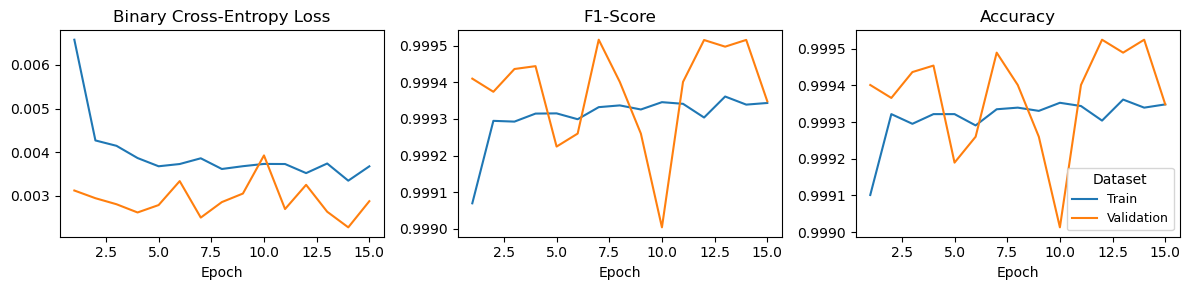

In [10]:
# visualizing loss, accuracy, and F1-Score for training set and validation set
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

epochs = range(1, len(conv_results1) + 1)

axes[0].plot(epochs, conv_model1_history.history['loss'], label='Train')
axes[0].plot(epochs, conv_model1_history.history['val_loss'], label='Validation')
axes[0].set(title='Binary Cross-Entropy Loss', xlabel='Epoch', ylabel='Loss')
axes[0].set_ylabel(None)

axes[1].plot(epochs, conv_model1_history.history['f1_score'], label='Train')
axes[1].plot(epochs, conv_model1_history.history['val_f1_score'], label='Validation')
axes[1].set(title='F1-Score', xlabel='Epoch', ylabel=None)

axes[2].plot(epochs, conv_model1_history.history['accuracy'], label='Train')
axes[2].plot(epochs, conv_model1_history.history['val_accuracy'], label='Validation')
axes[2].set(title='Accuracy', xlabel='Epoch', ylabel=None)
#axes[2].legend(loc=(1.1, 0.5), prop={'size': 9}, title='Dataset')
axes[2].legend(prop={'size': 9}, title='Dataset')

plt.tight_layout()
plt.show()

In [11]:
# get probabilities & extract predicted labels
probabilities = conv_model1.predict(X_test)
y_pred = np.argmax(probabilities > 0.5, axis=1)

# display examples
y_pred[15:30]

1774/1774 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [12]:
import sklearn.metrics as metrics

# non-normalized confusion matrix
pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred),
    index=['non-fraud (0)', 'fraud (1)'],
    columns=['non-fraud (0)', 'fraud (1)']
            )

,non-fraud (0),fraud (1)
non-fraud (0),56637,14
fraud (1),23,72


> 23 fraud transactions are missed out of 95 transactions (23 + 72). 14 regular transactions are missclassified out of 56651 transactions (14 + 56637).

In [13]:
# display classification report
class_report = metrics.classification_report(y_test, y_pred, output_dict=True)

pd.DataFrame(class_report).transpose().round(4)

,precision,recall,f1-score,support
0,0.9996,0.9998,0.9997,56651.0000
1,0.8372,0.7579,0.7956,95.0000
accuracy,0.9993,0.9993,0.9993,0.9993
macro avg,0.9184,0.8788,0.8976,56746.0000
weighted avg,0.9993,0.9993,0.9993,56746.0000


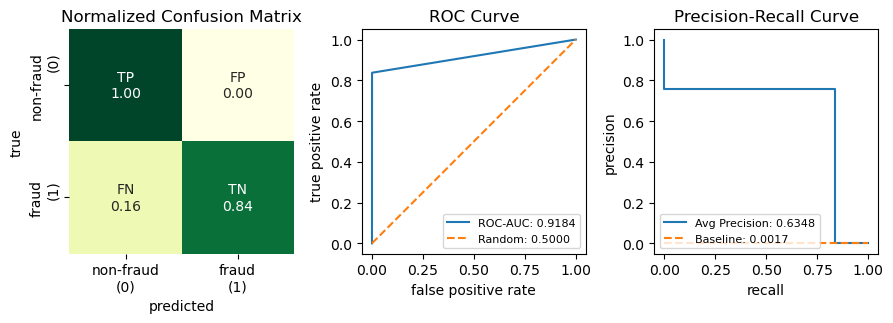

In [14]:
from seaborn import heatmap
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay

fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))

# confusion matrix features
quarters = ['TP', 'FP', 'FN', 'TN']
cm = confusion_matrix(y_pred, y_test, normalize='true')

values = ['{:.2f}'.format(value) for value in cm.flatten()]
label = [f'{i}\n{j}' for i, j in zip(quarters, values)]
labels = np.asarray(label).reshape(2, 2)

# heatmap properties
heatmap_kwargs = {
    'xticklabels': ['non-fraud\n(0)', 'fraud\n(1)'],
    'yticklabels': ['non-fraud\n(0)', 'fraud\n(1)'],
    'cbar': False,
    'cmap': 'YlGn',
    'fmt': '',
    'annot': labels,
    }

heatmap(cm, square=True, **heatmap_kwargs, ax=axes[0])
axes[0].set_title('Normalized Confusion Matrix')
axes[0].set_xlabel('predicted')
axes[0].set_ylabel('true')

fpr, tpr, _ = roc_curve(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)

RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f'ROC-AUC: {roc_auc:.4f}').plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], linestyle='--', label='Random: 0.5000')
axes[1].set_title('ROC Curve')
axes[1].set_xlim([-0.05, 1.05])
axes[1].set_ylim([-0.05, 1.05])
axes[1].set_xlabel('false positive rate')
axes[1].set_ylabel('true positive rate')
axes[1].legend(loc='lower right', fontsize=8)

# baseline, no-skill
no_skill = len(y_test[y_test == 1]) / len(y_test)
prec, rec, _ = precision_recall_curve(y_pred, y_test)
ap = average_precision_score(y_pred, y_test)

PrecisionRecallDisplay(prec, rec, estimator_name=f'Avg Precision: {ap:.4f}').plot(ax=axes[2])
axes[2].plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'Baseline: {no_skill:.4f}')
axes[2].set_title('Precision-Recall Curve')
axes[2].set_xlim([-0.05, 1.05])
axes[2].set_ylim([-0.05, 1.05])
axes[2].set_xlabel('recall')
axes[2].set_ylabel('precision')
axes[2].legend(loc='lower left', fontsize=8)
      
plt.tight_layout()
plt.show()

> The model does a great job in detecting positive cases (true positive rate - upper left tile). The convolution network correctly identified over 80% of fraud transactions (true negative rate - lower right tile). 16% of fraud cases were incorrectly classified (false positive rate - lower left tile).
>
> The ROC-AUC score and its curve consider very good performance, with a high degree of accuracy in distinguishing between the two classes.
>
> The average precision indicates moderate performance in terms of ability to rank predictions by relevance and precision. On average, the model is correctly identifying 63.48% of the positive samples when it predicts positive. This suggests that the model is making errors, with a fair proportion of false positives.

In [15]:
# evaluating the model on test set
# log loss (logisitc loss, also known as cross-entropy loss)
loss = metrics.log_loss(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)

# set list of scores
reg_scores = []
reg_scores.extend([loss, f1_score, precision, recall, accuracy])

table = PrettyTable(['Log Loss', 'F1-Score', 'Precision', 'Recall', 'Accuracy'], align='l', header_style=None)
table.add_row([round(loss, 4), round(f1_score, 4), round(precision, 4), round(recall, 4), round(accuracy, 4)])
print(table)

+----------+----------+-----------+--------+----------+
| Log Loss | F1-Score | Precision | Recall | Accuracy |
+----------+----------+-----------+--------+----------+
| 0.0235   | 0.7956   | 0.8372    | 0.7579 | 0.9993   |
+----------+----------+-----------+--------+----------+


> This neural network performs very well overall. The low logistic loss further supports this conclusion. The precision score indicates that when the model predicts the positive class (regular transactions), it is correct 83.72% of the time. The recall score indicates that the model correctly identifies 75.79% of all true positive samples. The network misses about 24% of positive cases. While the model does a fairly good job identifying positives, there is still room for improvement, especially to reduce false negatives (i.e., missing positive samples). The F1 score, which is a harmonic mean of precision and recall, indicates a good balance between these two. It still suggests there is room for improvement, especially in recall.

### 3. SMOTE & ENN Resampling

We will apply SMOTE and ENN oversampling to balance the dataset, fit the neural network with the same architecture, and check its performance with evaluation metrics.

In [16]:
# clear session, avoid clutter from old models & layers
keras.backend.clear_session()

In [17]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(sampling_strategy='minority', random_state=42)
X_smote_enn, y_smote_enn = smote_enn.fit_resample(X_train, y_train)

print(f'Shapes: {X_smote_enn.shape}, {y_smote_enn.shape}')

Shapes: (452807, 30), (452807,)


In [18]:
# reshape SMOTE-ENN feature data from 2D to 3D
X_train_3d = X_smote_enn.values.reshape(X_smote_enn.shape[0], X_smote_enn.shape[1], 1)
X_test_3d = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f'Unique target labels: {len(np.unique(y_smote_enn))}')
print(f'Shapes: {X_train_3d.shape}, {X_test_3d.shape}')

Unique target labels: 2
Shapes: (452807, 30, 1), (56746, 30, 1)


In [19]:
# initialize convoluted network & architecture
conv_model2 = keras.models.Sequential(name='Second_Conv_1D_model')
conv_model2.add(keras.layers.Conv1D(filters=40, kernel_size=10, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])))
conv_model2.add(keras.layers.Dropout(0.1))
conv_model2.add(keras.layers.Dense(35, activation='relu'))
conv_model2.add(keras.layers.Conv1D(filters=40, kernel_size=10, activation='relu'))
conv_model2.add(keras.layers.Dropout(0.1))
conv_model2.add(keras.layers.MaxPooling1D(pool_size=2))
conv_model2.add(keras.layers.Dropout(0.1))
conv_model2.add(keras.layers.Flatten())
conv_model2.add(keras.layers.Dense(2, activation='sigmoid'))

# display summary
#conv_model2.summary()

In [20]:
# run custom evaluation functions
def precision_func(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_func(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    precision = precision_func(y_true, y_pred)
    recall = recall_func(y_true, y_pred)
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1_score

# compile second model
conv_model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[f1_score, precision_func, recall_func, 'accuracy'],
)

In [21]:
# convert labels to one-hot encodings
y_train_cat = keras.utils.to_categorical(y_smote_enn)
y_test_cat = keras.utils.to_categorical(y_test)

# fit second model
conv_model2_history = conv_model2.fit(
    X_train_3d, 
    y_train_cat,
    epochs=15,
    verbose=1,
    validation_data=(X_test_3d, y_test_cat),
)

Epoch 1/15
14151/14151 ━━━━━━━━━━━━━━━━━━━━ 90s 6ms/step - accuracy: 0.9760 - f1_score: 0.9751 - loss: 0.0664 - precision_func: 0.9755 - recall_func: 0.9749 - val_accuracy: 0.9974 - val_f1_score: 0.9974 - val_loss: 0.0152 - val_precision_func: 0.9975 - val_recall_func: 0.9973
Epoch 2/15
14151/14151 ━━━━━━━━━━━━━━━━━━━━ 90s 6ms/step - accuracy: 0.9968 - f1_score: 0.9968 - loss: 0.0128 - precision_func: 0.9968 - recall_func: 0.9968 - val_accuracy: 0.9974 - val_f1_score: 0.9974 - val_loss: 0.0141 - val_precision_func: 0.9974 - val_recall_func: 0.9974
Epoch 3/15
14151/14151 ━━━━━━━━━━━━━━━━━━━━ 92s 7ms/step - accuracy: 0.9978 - f1_score: 0.9978 - loss: 0.0087 - precision_func: 0.9978 - recall_func: 0.9978 - val_accuracy: 0.9968 - val_f1_score: 0.9968 - val_loss: 0.0196 - val_precision_func: 0.9968 - val_recall_func: 0.9968
Epoch 4/15
14151/14151 ━━━━━━━━━━━━━━━━━━━━ 92s 6ms/step - accuracy: 0.9983 - f1_score: 0.9983 - loss: 0.0069 - precision_func: 0.9983 - recall_func: 0.9983 - val_accura

In [22]:
# display training results
conv_results2 = pd.DataFrame(conv_model2_history.history)
conv_results2.round(4)

,accuracy,f1_score,loss,precision_func,recall_func,val_accuracy,val_f1_score,val_loss,val_precision_func,val_recall_func
0,0.9890,0.9887,0.0347,0.9888,0.9886,0.9974,0.9974,0.0152,0.9975,0.9973
1,0.9971,0.9971,0.0119,0.9971,0.9970,0.9974,0.9974,0.0141,0.9974,0.9974
2,0.9978,0.9978,0.0090,0.9978,0.9978,0.9968,0.9968,0.0196,0.9968,0.9968
3,0.9982,0.9982,0.0072,0.9982,0.9982,0.9976,0.9976,0.0155,0.9976,0.9976
4,0.9982,0.9982,0.0070,0.9982,0.9982,0.9982,0.9982,0.0120,0.9982,0.9982
5,0.9985,0.9985,0.0064,0.9985,0.9985,0.9984,0.9984,0.0150,0.9984,0.9984
6,0.9987,0.9987,0.0061,0.9987,0.9987,0.9983,0.9983,0.0108,0.9983,0.9983
7,0.9986,0.9986,0.0060,0.9986,0.9986,0.9988,0.9988,0.0145,0.9988,0.9988
8,0.9986,0.9986,0.0061,0.9986,0.9986,0.9985,0.9985,0.0142,0.9985,0.9985
9,0.9988,0.9988,0.0055,0.9988,0.9988,0.9977,0.9977,0.0209,0.9977,0.9977


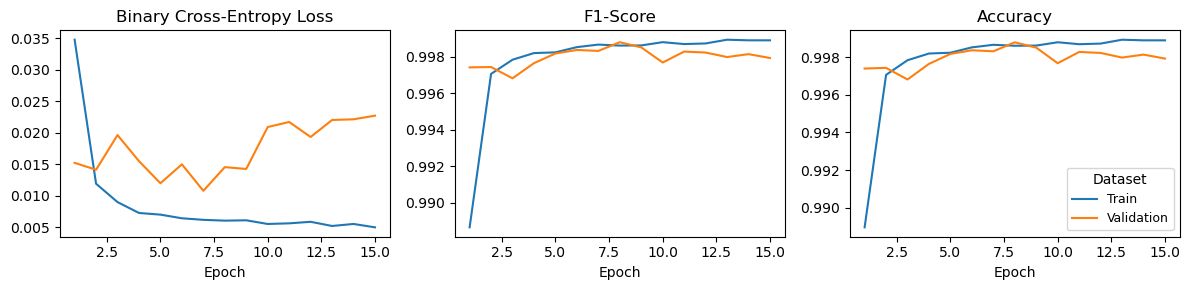

In [23]:
# visualizing loss, accuracy, and F1-Score for training set and validation set
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

epochs = range(1, len(conv_results2) + 1)

axes[0].plot(epochs, conv_model2_history.history['loss'], label='Train')
axes[0].plot(epochs, conv_model2_history.history['val_loss'], label='Validation')
axes[0].set(title='Binary Cross-Entropy Loss', xlabel='Epoch', ylabel='Loss')
axes[0].set_ylabel(None)

axes[1].plot(epochs, conv_model2_history.history['f1_score'], label='Train')
axes[1].plot(epochs, conv_model2_history.history['val_f1_score'], label='Validation')
axes[1].set(title='F1-Score', xlabel='Epoch', ylabel=None)

axes[2].plot(epochs, conv_model2_history.history['accuracy'], label='Train')
axes[2].plot(epochs, conv_model2_history.history['val_accuracy'], label='Validation')
axes[2].set(title='Accuracy', xlabel='Epoch', ylabel=None)
#axes[2].legend(loc=(1.1, 0.5), prop={'size': 9}, title='Dataset')
axes[2].legend(prop={'size': 9}, title='Dataset')

plt.tight_layout()
plt.show()

In [24]:
# get probabilities & extract predicted labels - other method
probabilities = conv_model2.predict(X_test)
y_pred = tf.argmax(probabilities, axis=1).numpy()

y_pred[1000:1025]

1774/1774 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

In [25]:
# non-normalized confusion matrix
pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred),
    index=['non-fraud (0)', 'fraud (1)'],
    columns=['non-fraud (0)', 'fraud (1)']
            )

,non-fraud (0),fraud (1)
non-fraud (0),56544,107
fraud (1),11,84


> 11 fraud transactions are missed out of 95 transactions. 107 non-fraud transactions are missclassified out of 56651 transactions.

In [26]:
# display classification report
class_report = metrics.classification_report(y_test, y_pred, output_dict=True)

pd.DataFrame(class_report).transpose().round(4)

,precision,recall,f1-score,support
0,0.9998,0.9981,0.9990,56651.0000
1,0.4398,0.8842,0.5874,95.0000
accuracy,0.9979,0.9979,0.9979,0.9979
macro avg,0.7198,0.9412,0.7932,56746.0000
weighted avg,0.9989,0.9979,0.9983,56746.0000


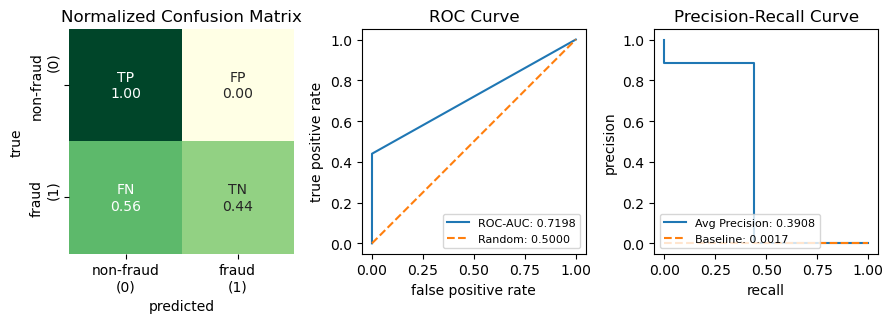

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))

# confusion matrix features
quarters = ['TP', 'FP', 'FN', 'TN']
cm = confusion_matrix(y_pred, y_test, normalize='true')

values = ['{:.2f}'.format(value) for value in cm.flatten()]
label = [f'{i}\n{j}' for i, j in zip(quarters, values)]
labels = np.asarray(label).reshape(2, 2)

# heatmap properties
heatmap_kwargs = {
    'xticklabels': ['non-fraud\n(0)', 'fraud\n(1)'],
    'yticklabels': ['non-fraud\n(0)', 'fraud\n(1)'],
    'cbar': False,
    'cmap': 'YlGn',
    'fmt': '',
    'annot': labels,
    }

heatmap(cm, square=True, **heatmap_kwargs, ax=axes[0])
axes[0].set_title('Normalized Confusion Matrix')
axes[0].set_xlabel('predicted')
axes[0].set_ylabel('true')

fpr, tpr, _ = roc_curve(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)

RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f'ROC-AUC: {roc_auc:.4f}').plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], linestyle='--', label='Random: 0.5000')
axes[1].set_title('ROC Curve')
axes[1].set_xlim([-0.05, 1.05])
axes[1].set_ylim([-0.05, 1.05])
axes[1].set_xlabel('false positive rate')
axes[1].set_ylabel('true positive rate')
axes[1].legend(loc='lower right', fontsize=8)

# baseline, no-skill
no_skill = len(y_test[y_test == 1]) / len(y_test)
prec, rec, _ = precision_recall_curve(y_pred, y_test)
ap = average_precision_score(y_pred, y_test)

PrecisionRecallDisplay(prec, rec, estimator_name=f'Avg Precision: {ap:.4f}').plot(ax=axes[2])
axes[2].plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'Baseline: {no_skill:.4f}')
axes[2].set_title('Precision-Recall Curve')
axes[2].set_xlim([-0.05, 1.05])
axes[2].set_ylim([-0.05, 1.05])
axes[2].set_xlabel('recall')
axes[2].set_ylabel('precision')
axes[2].legend(loc='lower left', fontsize=8)
      
plt.tight_layout()
plt.show()

> The high true positive rate (upper left tile) indicates that the model does an excellent job at identifying regular transactions. The significant false negatives (lower left tile) displays 56% of missing fraud transactions - over half of them. This should be a clear area of concern. The true negative rate (lower right tile) shows a modest value; nearly half of fraudulent transactions are correctly classified. There is a lot of room for improvement in detecting false transactions.
> 
> The ROC-AUC score shows the model is acceptable, yet there still is room for improvement.
> 
> The average precision is relatively low and reflects imbalance for recall and precision. The neural network is achieving some positive results, there is a substantial gap between recall and precision, meaning the model is not effectively maintaining high precision across recall thresholds. It struggles at ranking fraud transactions correctly.

In [28]:
# evaluating the model on test set
loss = metrics.log_loss(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)

# set list of scores
smote_enn_scores = []
smote_enn_scores.extend([loss, f1_score, precision, recall, accuracy])

table = PrettyTable(['Log Loss', 'F1-Score', 'Precision', 'Recall', 'Accuracy'], align='l', header_style=None)
table.add_row([round(loss, 4), round(f1_score, 4), round(precision, 4), round(recall, 4), round(accuracy, 4)])
print(table)

+----------+----------+-----------+--------+----------+
| Log Loss | F1-Score | Precision | Recall | Accuracy |
+----------+----------+-----------+--------+----------+
| 0.075    | 0.5874   | 0.4398    | 0.8842 | 0.9979   |
+----------+----------+-----------+--------+----------+


> The model's performance is moderate. The log loss indicates that the classifier's predicted probabilities are quite confident. The F1 score displays average trade-off between precision and recall. Recall is high however, it comes at the cost of lower precision, indicating that the model is likely classifying many fraud transactions as positive (false positives). In our case these false positives are costly. The network is prioritizing recall at the cost of precision. There is room for improvement and the classifier needs more balance between precision and recall.

### 4. Random Undersampling

Lastly, we will perform random undersampling to balance the dataset and repeat the same steps.

In [29]:
# clear session, avoid clutter from old models & layers
keras.backend.clear_session()

In [30]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_under, y_under = undersample.fit_resample(X_train, y_train)

print(f'Shapes: {X_under.shape}, {y_under.shape}')

Shapes: (756, 30), (756,)


In [31]:
# reshape SMOTE-ENN feature data from 2D to 3D
X_train_3d = X_under.values.reshape(X_under.shape[0], X_under.shape[1], 1)
X_test_3d = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f'Unique target labels: {len(np.unique(y_under))}')
print(f'Shapes: {X_train_3d.shape}, {X_test_3d.shape}')

Unique target labels: 2
Shapes: (756, 30, 1), (56746, 30, 1)


In [32]:
# initialize convoluted network & architecture
conv_model3 = keras.models.Sequential(name='Third_Conv_1D_model')
conv_model3.add(keras.layers.Conv1D(filters=40, kernel_size=10, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])))
conv_model3.add(keras.layers.Dropout(0.1))
conv_model3.add(keras.layers.Dense(35, activation='relu'))
conv_model3.add(keras.layers.Conv1D(filters=40, kernel_size=10, activation='relu'))
conv_model3.add(keras.layers.Dropout(0.1))
conv_model3.add(keras.layers.MaxPooling1D(pool_size=2))
conv_model3.add(keras.layers.Dropout(0.1))
conv_model3.add(keras.layers.Flatten())
conv_model3.add(keras.layers.Dense(2, activation='sigmoid'))

# display summary
#conv_model3.summary()

In [33]:
# run custom evaluation functions
def precision_func(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_func(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    precision = precision_func(y_true, y_pred)
    recall = recall_func(y_true, y_pred)
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1_score

# compile model
conv_model3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[f1_score, precision_func, recall_func, 'accuracy'],
)

In [34]:
# convert labels to one-hot encodings
y_train_cat = keras.utils.to_categorical(y_under)
y_test_cat = keras.utils.to_categorical(y_test)

# fit third model
conv_model3_history = conv_model3.fit(
    X_train_3d,
    y_train_cat,
    epochs=15,
    verbose=1,
    validation_data=(X_test_3d, y_test_cat),
)

Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.5821 - f1_score: 0.6027 - loss: 0.5267 - precision_func: 0.6017 - recall_func: 0.6109 - val_accuracy: 0.9791 - val_f1_score: 0.9764 - val_loss: 0.4913 - val_precision_func: 0.9814 - val_recall_func: 0.9717
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.9350 - f1_score: 0.9292 - loss: 0.2926 - precision_func: 0.9352 - recall_func: 0.9235 - val_accuracy: 0.9789 - val_f1_score: 0.9782 - val_loss: 0.2753 - val_precision_func: 0.9802 - val_recall_func: 0.9763
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.9153 - f1_score: 0.9206 - loss: 0.2388 - precision_func: 0.9186 - recall_func: 0.9227 - val_accuracy: 0.9708 - val_f1_score: 0.9702 - val_loss: 0.2079 - val_precision_func: 0.9685 - val_recall_func: 0.9721
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.9288 - f1_score: 0.9257 - loss: 0.2020 - precision_func: 0.9294 - recall_func: 0.9224 - val_accuracy: 0.9611 - val_f1_

In [35]:
# display training results
conv_results3 = pd.DataFrame(conv_model3_history.history)
conv_results3.round(4)

,accuracy,f1_score,loss,precision_func,recall_func,val_accuracy,val_f1_score,val_loss,val_precision_func,val_recall_func
0,0.7011,0.7064,0.4520,0.7214,0.6958,0.9791,0.9764,0.4913,0.9814,0.9717
1,0.9272,0.9254,0.2838,0.9280,0.9229,0.9789,0.9782,0.2753,0.9802,0.9763
2,0.9206,0.9268,0.2243,0.9241,0.9297,0.9708,0.9702,0.2079,0.9685,0.9721
3,0.9339,0.9318,0.1949,0.9345,0.9294,0.9611,0.9605,0.2147,0.9561,0.9652
4,0.9339,0.9362,0.1805,0.9345,0.9380,0.9681,0.9676,0.1893,0.9684,0.9669
5,0.9458,0.9405,0.1586,0.9390,0.9422,0.9185,0.9157,0.3064,0.9212,0.9107
6,0.9484,0.9454,0.1628,0.9440,0.9471,0.9420,0.9408,0.2434,0.9389,0.9428
7,0.9431,0.9435,0.1403,0.9418,0.9456,0.9501,0.9492,0.2135,0.9473,0.9513
8,0.9577,0.9510,0.1314,0.9506,0.9518,0.9556,0.9550,0.1897,0.9541,0.9561
9,0.9511,0.9507,0.1252,0.9511,0.9508,0.9472,0.9471,0.2054,0.9438,0.9506


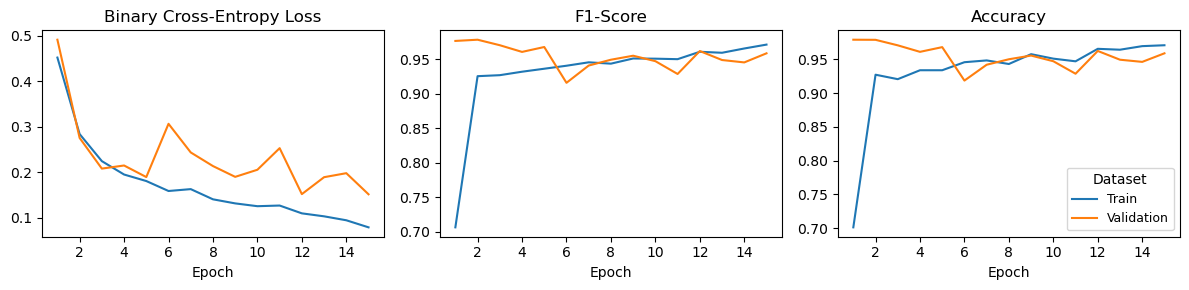

In [36]:
# visualizing loss, accuracy, and F1-Score for training set and validation set
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

epochs = range(1, len(conv_results3) + 1)

axes[0].plot(epochs, conv_model3_history.history['loss'], label='Train')
axes[0].plot(epochs, conv_model3_history.history['val_loss'], label='Validation')
axes[0].set(title='Binary Cross-Entropy Loss', xlabel='Epoch', ylabel='Loss')
axes[0].set_ylabel(None)

axes[1].plot(epochs, conv_model3_history.history['f1_score'], label='Train')
axes[1].plot(epochs, conv_model3_history.history['val_f1_score'], label='Validation')
axes[1].set(title='F1-Score', xlabel='Epoch', ylabel=None)

axes[2].plot(epochs, conv_model3_history.history['accuracy'], label='Train')
axes[2].plot(epochs, conv_model3_history.history['val_accuracy'], label='Validation')
axes[2].set(title='Accuracy', xlabel='Epoch', ylabel=None)
#axes[2].legend(loc=(1.1, 0.5), prop={'size': 9}, title='Dataset')
axes[2].legend(prop={'size': 9}, title='Dataset')

plt.tight_layout()
plt.show()

In [37]:
# get probabilities & extract predicted labels
probabilities = conv_model3.predict(X_test)
y_pred = tf.argmax(probabilities, axis=1).numpy()

y_pred[2050:2080]

1774/1774 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0], dtype=int64)

In [38]:
# non-normalized confusion matrix
pd.DataFrame(
    metrics.confusion_matrix(y_test, y_pred),
    index=['non-fraud (0)', 'fraud (1)'],
    columns=['non-fraud (0)', 'fraud (1)']
            )

,non-fraud (0),fraud (1)
non-fraud (0),54325,2326
fraud (1),4,91


> 4 fraud transactions are missed out of 95 transactions. 2326 non-fraud transactions are missclassified out of 56651 transactions.

In [39]:
# display classification report
class_report = metrics.classification_report(y_test, y_pred, output_dict=True)

pd.DataFrame(class_report).transpose().round(4)

,precision,recall,f1-score,support
0,0.9999,0.9589,0.9790,56651.0000
1,0.0376,0.9579,0.0725,95.0000
accuracy,0.9589,0.9589,0.9589,0.9589
macro avg,0.5188,0.9584,0.5257,56746.0000
weighted avg,0.9983,0.9589,0.9775,56746.0000


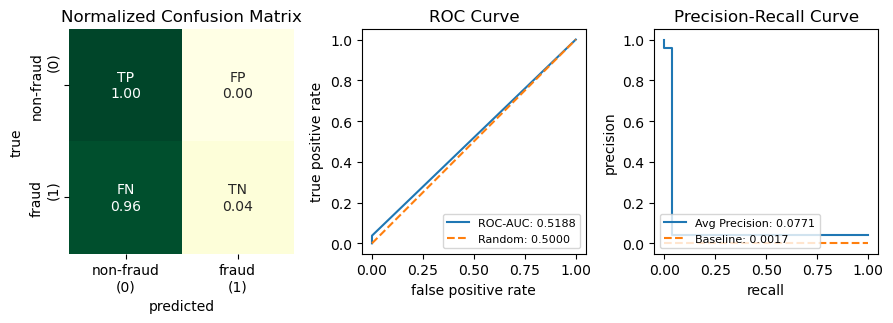

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))

# confusion matrix features
quarters = ['TP', 'FP', 'FN', 'TN']
cm = confusion_matrix(y_pred, y_test, normalize='true')

values = ['{:.2f}'.format(value) for value in cm.flatten()]
label = [f'{i}\n{j}' for i, j in zip(quarters, values)]
labels = np.asarray(label).reshape(2, 2)

# heatmap properties
heatmap_kwargs = {
    'xticklabels': ['non-fraud\n(0)', 'fraud\n(1)'],
    'yticklabels': ['non-fraud\n(0)', 'fraud\n(1)'],
    'cbar': False,
    'cmap': 'YlGn',
    'fmt': '',
    'annot': labels,
    }

heatmap(cm, square=True, **heatmap_kwargs, ax=axes[0])
axes[0].set_title('Normalized Confusion Matrix')
axes[0].set_xlabel('predicted')
axes[0].set_ylabel('true')

fpr, tpr, _ = roc_curve(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)

RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f'ROC-AUC: {roc_auc:.4f}').plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], linestyle='--', label='Random: 0.5000')
axes[1].set_title('ROC Curve')
axes[1].set_xlim([-0.05, 1.05])
axes[1].set_ylim([-0.05, 1.05])
axes[1].set_xlabel('false positive rate')
axes[1].set_ylabel('true positive rate')
axes[1].legend(loc='lower right', fontsize=8)

# baseline, no-skill
no_skill = len(y_test[y_test == 1]) / len(y_test)
prec, rec, _ = precision_recall_curve(y_pred, y_test)
ap = average_precision_score(y_pred, y_test)

PrecisionRecallDisplay(prec, rec, estimator_name=f'Avg Precision: {ap:.4f}').plot(ax=axes[2])
axes[2].plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'Baseline: {no_skill:.4f}')
axes[2].set_title('Precision-Recall Curve')
axes[2].set_xlim([-0.05, 1.05])
axes[2].set_ylim([-0.05, 1.05])
axes[2].set_xlabel('recall')
axes[2].set_ylabel('precision')
axes[2].legend(loc='lower left', fontsize=8)
      
plt.tight_layout()
plt.show()

> This model clearly does not recognize fraudulent tranasctions, yet performs very well on non-fraud class.
>
> The ROC curve visualizes that the network performs random guesses.
>
> There is an extremely high imbalance between precision and recall - extremely high recall and extremely low precision. The model is very conservative or selective in predicting the positive class. Random undersampling is not an effective implementation.

In [41]:
# evaluating the model on test set
loss = metrics.log_loss(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)

# set list of scores
under_scores = []
under_scores.extend([loss, f1_score, precision, recall, accuracy])

table = PrettyTable(['Log Loss', 'F1-Score', 'Precision', 'Recall', 'Accuracy'], align='l', header_style=None)
table.add_row([round(loss, 4), round(f1_score, 4), round(precision, 4), round(recall, 4), round(accuracy, 4)])
print(table)

+----------+----------+-----------+--------+----------+
| Log Loss | F1-Score | Precision | Recall | Accuracy |
+----------+----------+-----------+--------+----------+
| 1.48     | 0.0725   | 0.0376    | 0.9579 | 0.9589   |
+----------+----------+-----------+--------+----------+


> Random undersampling leads to a model that detects most regular transactions (high recall) but at the cost of an extremely low precision. This results in a very poor F1 score, which shows that the model is highly unbalanced. It struggles at predicting fraud samples. The high log loss further suggests poor confidence in its predictions. The classifier is essentially over-predicting the positive class and making many false positive predictions. This resampling method is not advisable in its current form because the model is untrustworthy and would likely generate more false positives than useful results.

In [42]:
# sum all evaluation metrics in tabular form
pd.DataFrame(
    data=[reg_scores, smote_enn_scores, under_scores],
    index=['No Sampling', 'SMOTE-ENN', 'Random Undersampling'],
    columns=['Log Loss', 'F1-Score', 'Precision', 'Recall', 'Accuracy'],
            ).round(4)

,Log Loss,F1-Score,Precision,Recall,Accuracy
No Sampling,0.0235,0.7956,0.8372,0.7579,0.9993
SMOTE-ENN,0.0750,0.5874,0.4398,0.8842,0.9979
Random Undersampling,1.4800,0.0725,0.0376,0.9579,0.9589


### 5. Conclusions

The object of this notebook was to perform a binary classification problem with convoluted neural networks. We trained three different models using the same architecture. From a previous notebook we discovered extreme imbalance within the dataset. First model was trained without applying resampling. The remaining networks were fitted with balanced datasets. The model evaluations were performed with standard metrics and plots (confusion matrices, ROC curves).

Firstly, it is easy to notice that the accuracy metrics are misleading. They are very high, but the remaining scores provide more detail of the performances. It is important to choose the model that has the highest balance between precision and recall. F1 score is the harmonic mean between these two scores.

Suprisingly, providing no sampling is the optimal strategy. It has the best balance overall, especially in terms of precision, recall, and log loss. The convoluted network does a good job detecting transactions. The SMOTE-ENN application is a moderate choice and would be acceptable if recall is critical. We should definitely avoid random undersampling. This method probably throws away data information which leads to a model that does not generalize well. The high very log loss, indicates that the model's predicted probabilities are much less reliable or far from the actual outcomes.

**References:**
* S. Kiranyaz, O. Avci, O. Abdeljaber, T. Ince, M. Gabbouj, D.J. Inman, 2021, *1D convolutional neural networks and applications: A survey*, [Full Text](https://www.sciencedirect.com/science/article/pii/S0888327020307846/pdfft?md5=ef09c32e1df9913fc58a6d6835b439fb&pid=1-s2.0-S0888327020307846-main.pdf)